In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm
from sklearn.utils import shuffle


In [2]:
from NeuralNetwork.dense import Dense
from NeuralNetwork.activations import Sigmoid,Softmax,ReLU
from NeuralNetwork.losses import categorical_crossentropy, categorical_crossentropy_derive,mse,mse_derive,binary_crossentropy,binary_crossentropy_derive
from NeuralNetwork.network import predict

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
X = mnist.data/255.0
labels = np.array( mnist.target).astype(int)

In [5]:
#y = np.squeeze(np.eye(10)[labels])

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,labels,test_size=0.2,shuffle=True)

In [7]:
X_val, y_val = X_train.iloc[:5000],y_train[:5000]
X_train, y_train = X_train.iloc[5000:],y_train[5000:]

In [8]:
EPOCH = 20
ALPHA = 0.08

In [9]:
def encode(z):
    if z>=0.5:
        return 1
    return 0

In [10]:

def train(NN, loss, loss_derive, X, Y, X_val,Y_val, epoch=EPOCH, alpha=ALPHA, verbose = True):
    error_TS = []
    acc_TS = []
    val_acc_TS = []
    val_error_TS = []
    for e in range(epoch):
        errors = 0
        acc = 0
        val_acc = 0
        val_error = 0
        for x, y in zip(X, Y):
            out = predict(NN, x)
            if y==encode(out):
                acc+=1
            errors += loss(y, out)
            gradient = loss_derive(y, out)
            for layer in reversed(NN):
                gradient = layer.backward(gradient, alpha)

        for x, y in zip(X_val, Y_val):
            output = predict(NN, x)
            if y==encode(output):
                val_acc+=1
            val_error += loss(y, output)

        errors /= len(X)
        acc /=len(X)
        val_error /= len(X_val)
        val_acc /=len(X_val)
        if verbose:
            print(f"{e + 1}/{epoch}, error={round(errors,4)}, accuracy={round(acc,4)}, val_error={round(val_error,4)}, val_accuracy={round(val_acc,4)}")
        error_TS.append(errors)
        acc_TS.append(acc)
        val_error_TS.append(val_error)
        val_acc_TS.append(val_acc)
    return [error_TS,acc_TS,val_error_TS,val_acc_TS]

class TreeNN():
    def __init__(self,depth=1,max_depth=3,parent_node = None):
        self.parent_node = parent_node
        self.NN = [
            Dense(784,1),
            Sigmoid()
        ]
        self.depth = depth
        self.max_depth = max_depth
        self.children = []
    
    def get_augemented(self,X,Y):
        Xa_train = []
        Xb_train = []
        for x, y in zip(X, Y):
            output = encode(predict(self.NN, x))
            if y!=output:
                if output==0 and y==1:
                    Xa_train.append(1)
                    Xb_train.append(0)
                if output==1 and y==0:
                    Xa_train.append(0)
                    Xb_train.append(1)

            else:
                if output==0 and y==0:
                    Xa_train.append(0)
                    Xb_train.append(1)

                if output==1 and y==1:
                    Xa_train.append(1)
                    Xb_train.append(0)
        return Xa_train,Xb_train
    
    def plot(self,metrics):
        metrics_names = ['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy']
        for i in range(len(metrics_names)):
            plt.plot(metrics[i])
            plt.xlabel("Epochs")
            plt.ylabel(metrics_names[i])
            plt.savefig("./graph/MNIST_{}_{}.png".format(metrics_names[i],self.depth))
            plt.clf()


    
    def train_tree(self,X,Y,X_val,Y_val):
        print("Layers :",self.depth)
        X_train = np.reshape(X,X.shape +(1,))
        Y_train = np.reshape(Y,Y.shape +(1,))
        X_val_in =np.reshape(X_val,X_val.shape +(1,))
        Y_val_in =np.reshape(Y_val,Y_val.shape +(1,))
        metrics = train(self.NN,binary_crossentropy,binary_crossentropy_derive,X_train,Y_train,X_val_in,Y_val_in)
        self.plot(metrics)
        if self.max_depth>self.depth+1:
            ## Adding Layers
            Na = TreeNN(depth=self.depth+1,max_depth=self.max_depth,parent_node=self)
            Nb = TreeNN(depth=self.depth+1,max_depth=self.max_depth,parent_node=self)
            self.children.append(Na)
            self.children.append(Nb)
            #Retrain with extra feature
            Xa_train,Xb_train = self.get_augemented(X_train,Y_train)
            X_retrain = np.column_stack((X, Xa_train))
            X_retrain = np.column_stack((X_retrain, Xb_train))
            X_retrain = np.reshape(X_retrain,X_retrain.shape+(1,))
            Xa,Xb = self.get_augemented(X_val_in,Y_val_in)
            X_reval = np.column_stack((X_val, Xa))
            X_reval = np.column_stack((X_reval, Xb))
            X_reval = np.reshape(X_reval,X_reval.shape+(1,))
            self.NN = [Dense(786,1),Sigmoid()]
            metrics = train(self.NN,mse,mse_derive,X_retrain,Y_train,X_reval,Y_val_in)
            self.plot(metrics)
            #Na
            self.children[0].train_tree(X,np.asanyarray(Xa_train),X_val,np.asanyarray(Xa))
            #Nb
            self.children[1].train_tree(X,np.asanyarray(Xb_train),X_val,np.asanyarray(Xb))

    def predict(self,X):
        if self.depth>self.max_depth:
            return  None  
        predictions = []

        if self.children == []:
            X_train = np.reshape(X,X.shape +(1,))
        else:
            Xa = self.children[0].predict(X)
            Xb = self.children[1].predict(X)
            Xa_encode = []
            Xb_encode = []
            for xa,xb in zip(Xa,Xb):
                Xa_encode.append(encode(xa))
                Xb_encode.append(encode(xb))
            X_train = np.column_stack((X, Xa_encode))
            X_train = np.column_stack((X_train, Xb_encode))
            X_train = np.reshape(X_train,X_train.shape+(1,))
        for x in X_train:
            output = predict(self.NN,x)
            predictions.append(output)

        return predictions
        # check for more probability
    

In [11]:

def oversample(X_train,Y_train):
    X_train_df = pd.DataFrame(X_train)
    Y_train_series = pd.Series(Y_train)
    X_train_df = X_train_df.reset_index(drop=True)
    Y_train_series = Y_train_series.reset_index(drop=True)
    class_0 = X_train_df[Y_train_series == 0]
    class_1 = X_train_df[Y_train_series == 1]
    max_samples = max(len(class_0), len(class_1))
    class_0_upsampled = class_0.sample(max_samples, replace=True, random_state=42) if len(class_0) < max_samples else class_0
    class_1_upsampled = class_1.sample(max_samples, replace=True, random_state=42) if len(class_1) < max_samples else class_1
    X_train_balanced = pd.concat([class_0_upsampled, class_1_upsampled])
    Y_train_balanced = pd.Series([0] * max_samples + [1] * max_samples)
    X_train_balanced, Y_train_balanced = shuffle(X_train_balanced, Y_train_balanced, random_state=42)
    X_train_balanced = X_train_balanced.to_numpy()
    Y_train_balanced = Y_train_balanced.to_numpy()
    print(f"Balanced dataset shape: {X_train_balanced.shape}, {Y_train_balanced.shape}")
    return X_train_balanced,Y_train_balanced

def undersample(X_train, Y_train):
    X_train_df = pd.DataFrame(X_train)
    Y_train_series = pd.Series(Y_train)
    X_train_df = X_train_df.reset_index(drop=True)
    Y_train_series = Y_train_series.reset_index(drop=True)
    
    # Separate classes
    class_0 = X_train_df[Y_train_series == 0]
    class_1 = X_train_df[Y_train_series == 1]
    
    # Determine minimum sample size
    min_samples = min(len(class_0), len(class_1))
    
    # Downsample both classes to match the smaller class
    class_0_downsampled = class_0.sample(min_samples, random_state=42)
    class_1_downsampled = class_1.sample(min_samples, random_state=42)
    
    # Combine downsampled classes and shuffle
    X_train_balanced = pd.concat([class_0_downsampled, class_1_downsampled])
    Y_train_balanced = pd.Series([0] * min_samples + [1] * min_samples)
    X_train_balanced, Y_train_balanced = shuffle(X_train_balanced, Y_train_balanced, random_state=42)
    
    # Convert to numpy arrays
    X_train_balanced = X_train_balanced.to_numpy()
    Y_train_balanced = Y_train_balanced.to_numpy()
    
    print(f"Balanced dataset shape: {X_train_balanced.shape}, {Y_train_balanced.shape}")
    return X_train_balanced, Y_train_balanced

In [12]:
def get_XY(X_train,y_train,X_val,y_val,y_test,class_):
    y_in = np.where(y_train == class_, 1, 0)
    y_v = np.where(y_val == class_, 1, 0)
    y_t = np.where(y_test == class_, 1, 0)
    X_in,y_in= oversample(X_train,y_in)
    X_v,y_v= oversample(X_val,y_v)
    return X_in,y_in,X_v,y_v,y_t


In [13]:
tree_classifier = []
for classifier in tqdm.tqdm(range(10)):
    root = TreeNN(max_depth=3,parent_node=None)
    X_in,y_in,X_v,y_v,y_t = get_XY(X_train,y_train,X_val,y_val,y_test,classifier)
    root.train_tree(X_in,y_in,X_v,y_v)
    tree_classifier.append(root)
    pred = root.predict(X_test)
    acc = 0
    error = 0
    for p,t in zip(pred,y_t):
        if encode(p)==t:
            acc+=1
        error+=mse(p,t)
    print("Test Accuracy = ",acc/len(y_t))
    print("Test Loss = ",error/len(y_t))

  0%|          | 0/10 [00:00<?, ?it/s]

Balanced dataset shape: (91928, 784), (91928,)
Balanced dataset shape: (8964, 784), (8964,)
Layers : 1
1/20, error=0.1019, accuracy=0.9762, val_error=0.1185, val_accuracy=0.9742
2/20, error=0.0786, accuracy=0.9807, val_error=0.1061, val_accuracy=0.9774
3/20, error=0.0733, accuracy=0.9817, val_error=0.104, val_accuracy=0.9772
4/20, error=0.0701, accuracy=0.9824, val_error=0.1061, val_accuracy=0.9766
5/20, error=0.0681, accuracy=0.9829, val_error=0.1094, val_accuracy=0.976
6/20, error=0.0666, accuracy=0.9832, val_error=0.112, val_accuracy=0.9753
7/20, error=0.0656, accuracy=0.9834, val_error=0.1143, val_accuracy=0.9749
8/20, error=0.0648, accuracy=0.9836, val_error=0.117, val_accuracy=0.9747
9/20, error=0.0642, accuracy=0.9839, val_error=0.1194, val_accuracy=0.9752
10/20, error=0.0637, accuracy=0.9841, val_error=0.1215, val_accuracy=0.9751
11/20, error=0.0633, accuracy=0.9842, val_error=0.1235, val_accuracy=0.9755
12/20, error=0.0629, accuracy=0.9843, val_error=0.1252, val_accuracy=0.974

<Figure size 640x480 with 0 Axes>

In [51]:
def predict_tree_classifiers(tree_classifier,X_sample):
    predictions = []
    pred_all = []
    for classifier in tree_classifier:
        pred = classifier.predict(X_sample)
        pred_all.append(pred)
    predicts = np.array(pred_all).squeeze().transpose()
    for pred in predicts:
        predictions.append(pred)
    return np.array(predictions)

In [60]:
def eval_tree(tree_classifier,X_sample,y_sample):
    predictions = predict_tree_classifiers(tree_classifier,X_sample)
    acc = 0
    for pred,true in zip(predictions,y_sample):
        if np.argmax(pred)==true:
            acc+=1
    return acc/len(X_sample)

In [61]:
eval_tree(tree_classifier,X_test,y_test)

0.8036428571428571

In [71]:
X_test.shape

(14000, 784)

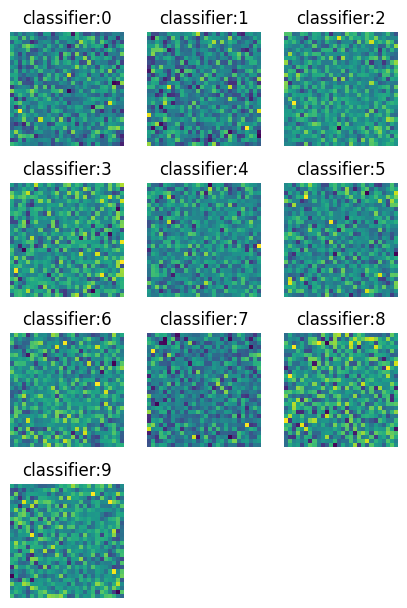

In [40]:
index =0
fig = plt.figure(figsize=(5, 7.5)) 

rows = 4
columns = 3
for classifier in tree_classifier:
    fig.add_subplot(rows, columns, index+1) 
    plt.imshow(classifier.NN[0].weights.squeeze()[:-2].reshape(28,28))
    plt.axis('off') 
    plt.title('classifier:{}'.format(index))
    index+=1

In [62]:
from sklearn.utils import shuffle
def get_top(X,labels,k=100):
    #dataset = np.column_stack((X,labels))
    X_sample, labels_sample = shuffle(X, labels, )

    topk = []
    for _class in range(10):
        class_index = np.where(labels_sample==_class)[0][:k]
        topk.append(np.column_stack((X_sample.iloc[class_index],labels_sample[class_index])))
    topk = np.vstack(topk)
    return topk

In [79]:
top100 = get_top(X,labels)
np.random.shuffle(top100)

In [80]:
pairs = []
pair_labels = []
for row1 in top100:
    for row2 in top100:
        pairs.append(np.hstack((row2[:-1],row1[:-1])))
        if row1[-1]==row2[-1]:
            pair_labels.append(1)
        else:
            pair_labels.append(0)

pairs = np.vstack(pairs)
pair_labels = np.array(pair_labels)

In [98]:
def predict_siamese(tree_classifier,X,threshold=0.5):
    X_sample = X.reshape(len(X), 2, 784)
    predictions = []
    first_images = []
    second_images = []
    
    for sample in X_sample:
        first_images.append(predict_tree_classifiers(tree_classifier,sample[0].reshape(1,784)))
        second_images.append(predict_tree_classifiers(tree_classifier,sample[1].reshape(1,784)))

    for first,second in zip(first_images,second_images):
        euclidean_dist =np.sqrt(np.sum(np.square(first - second)))
        if euclidean_dist<threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [82]:
X_train,X_val,y_train,y_val = train_test_split(pairs,pair_labels,test_size=0.2,shuffle=True)

In [100]:
predictions = predict_siamese(tree_classifier,X_val)

In [102]:
acc = 0
for pred,true in zip(predictions,y_val):
    if pred==true:
        acc+=1
print( acc/len(y_val))

0.931895


In [108]:
def eval(predictions,true_val):
    acc = 0
    for pred,true in zip(predictions,true_val):
        if pred==true:
            acc+=1
    return acc/len(true_val)

In [116]:
def eval_siamese(X_sample,label_sample,k=5):
    topk = get_top(X,labels,k)
    np.random.shuffle(topk)
    predictions = []
    for sample in tqdm.tqdm(X_sample.to_numpy()):
        pairs = []
        pair_labels = []
        for row in topk:
            pairs.append(np.hstack((sample[:],row[:-1])))
            pair_labels.append(row[-1])
        pairs = np.vstack(pairs)
        pair_labels = np.array(pair_labels).astype(int)
        sample_predictions = predict_siamese(tree_classifier,pairs)
        predict = np.bincount(pair_labels[sample_predictions==1])
        if predict.size:
            predictions.append(predict.argmax())
        else:
            predictions.append(10)
    acc = eval(np.array(predictions),label_sample)
    return {'k':k,'acc':acc}

In [120]:
eval_siamese(X_test.iloc[:100],y_test[:100],k=300)

  0%|          | 0/100 [00:00<?, ?it/s]

{'k': 300, 'acc': 0.81}

In [121]:
y_test

array([0, 3, 9, ..., 7, 3, 1])